In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Import standard libraries
import os, sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import astropy.units as u
import emcee, corner
import seaborn as sns
import pandas as pd

import chimera

import coronagraph as cg
import smart
import smarter; smarter.utils.plot_setup()

/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/lustija1/Documents/PandExo_data/pysynphot_data/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/lustija1/Documents/PandExo_data/pysynphot_data/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/lustija1/Documents/PandExo_data/pysynphot_data/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
from run_wasp43_mcmc import *

Loading Synthetic Data and xsecs...


In [3]:
class Gas(object):
    
    def __init__(self, default = -15.0, **kwargs):
        
        # Unpacking gas scale factors
        self.H2O = kwargs.get("H2O", default)
        self.CH4 = kwargs.get("CH4", default)
        self.CO = kwargs.get("CO", default)
        self.CO2 = kwargs.get("CO2", default)
        self.NH3 = kwargs.get("NH3", default)
        self.N2 = kwargs.get("N2", default)
        self.HCN = kwargs.get("HCN", default)
        self.H2S = kwargs.get("H2S", default)
        self.PH3 = kwargs.get("PH3", default)
        self.C2H2 = kwargs.get("C2H2", default)
        self.C2H6 = kwargs.get("C2H6", default)
        self.Na = kwargs.get("Na", default)
        self.K = kwargs.get("K", default)
        self.TiO = kwargs.get("TiO", default)
        self.VO = kwargs.get("VO", default)
        self.FeH = kwargs.get("FeH", default)
        self.H = kwargs.get("H", default)
        self.H2 = kwargs.get("H2", default)
        self.He = kwargs.get("He", default)
        self.em = kwargs.get("em", default)
        self.hm = kwargs.get("hm", default)
        self.mmw = kwargs.get("mmw", default)
        
        return
    
    def get_gas_scale(self):
        gas_scale = np.array([self.H2O, self.CH4, self.CO, self.CO2, self.NH3,
                              self.N2, self.HCN, self.H2S, self.PH3, self.C2H2,
                              self.C2H6, self.Na, self.K, self.TiO, self.VO,
                              self.FeH, self.H, self.H2, self.He, self.em, self.hm, 
                              self.mmw])
        return gas_scale

In [4]:
gases = Gas(default=1.0)
gases.get_gas_scale()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [6]:
"""
FORWARD MODEL & LIKELIHOOD
"""

# Initialize as empty
THETA_NAMES = []

# Initial conditions
THETA_DEFAULTS = {
    "Rp" : 0.93,
    "Rstar" : 0.6629, #0.6,
    "M" : 1.776,
    "D" : 0.014,
    "Tirr" : 1000,
    "logKir" : -1.5,
    "logg1" : -0.7,
    "Tint" : 200,
    "logMet" : 0.0, #2.0,
    "logCtoO": -0.26, #-1.0,
    "logPQCarbon" : -5.5,
    "logPQNitrogen" : -5.5,
    "logKzz" : 7,
    "fsed" : 2.0,
    "logPbase" : -1.0,
    "logCldVMR" : -5.5,
    "logKcld" : -40,
    "logRayAmp" : -30,
    "RaySlope" : 0,
    "Teff" : 4305.0, #4400.,
    "logMH" : -0.05,
    "logg" : 4.646,
    "d" : 86.7467#80.0
}

GAS_LIST = [
    "H2O", "CH4", "CO", "CO2", "NH3", "N2", "HCN", "H2S", "PH3",  
    "C2H2", "C2H6", "Na", "K", "TiO", "VO", "FeH", "H", "H2", "He", 
    "em", "hm", "mmw"
]

GAS_DEFAULTS = {
    gas : 1.0
    for gas in GAS_LIST
}

def run_pie_model_general(theta):
    """
    """

    # Create dictionary
    theta_dict = dict(zip(THETA_NAMES, theta))

    # Unpack parameters to retrieve if they are in state vector
    # otherwise use the default fixed values

    #setup "input" parameters. We are defining our 1D atmosphere with these
    #the parameters
    #planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
    Rp = theta_dict.get("Rp", THETA_DEFAULTS["Rp"])      # Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
    Rstar = theta_dict.get("Rstar", THETA_DEFAULTS["Rstar"]) # Stellar Radius in Solar Radii
    M = theta_dict.get("M", THETA_DEFAULTS["M"])       # Mass in Jupiter Masses
    D=theta_dict.get("D", THETA_DEFAULTS["D"])        # Semimajor axis in AU--for reflected light component

    #TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
    Tirr=theta_dict.get("Tirr", THETA_DEFAULTS["Tirr"])       # Irradiation temperature as defined in Guillot 2010
    logKir=theta_dict.get("logKir", THETA_DEFAULTS["logKir"])   # TP profile IR opacity (log there-of) controlls the "vertical" location of the gradient
    logg1=theta_dict.get("logg1", THETA_DEFAULTS["logg1"])     # single channel Vis/IR (log) opacity. Controls the delta T between deep T and TOA T
    Tint=theta_dict.get("Tint", THETA_DEFAULTS["Tint"])        # interior temperature...this would be the "effective temperature" if object were not irradiated

    #Composition parameters---assumes "chemically consistent model" described in Kreidberg et al. 2015
    logMet=theta_dict.get("logMet", THETA_DEFAULTS["logMet"])                # Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1: valid range is -1.5 - 3.0
    logCtoO=theta_dict.get("logCtoO", THETA_DEFAULTS["logCtoO"])            # log C-to-O ratio: log solar is -0.26: valid range is -1.0 - 0.3
    logPQCarbon=theta_dict.get("logPQCarbon", THETA_DEFAULTS["logPQCarbon"])     # CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value: valid range -6.0 - 1.5
    logPQNitrogen=theta_dict.get("logPQNitrogen", THETA_DEFAULTS["logPQNitrogen"]) # N2, NH3 Quench pressure--forces N2 and NH3 to ""

    #Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
    logKzz=theta_dict.get("logKzz", THETA_DEFAULTS["logKzz"])          # log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
    fsed=theta_dict.get("fsed", THETA_DEFAULTS["fsed"])            # sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud
    logPbase=theta_dict.get("logPbase", THETA_DEFAULTS["logPbase"])   # cloud base pressure--valid range: -6.0 - 1.5
    logCldVMR=theta_dict.get("logCldVMR", THETA_DEFAULTS["logCldVMR"]) # cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

    #simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
    #(most are just made up anyway since we don't really understand all of the micro-physics.....)
    logKcld = theta_dict.get("logKcld", THETA_DEFAULTS["logKcld"])      # uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10
    logRayAmp = theta_dict.get("logRayAmp", THETA_DEFAULTS["logRayAmp"])  # power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3
    RaySlope = theta_dict.get("RaySlope", THETA_DEFAULTS["RaySlope"])      # power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6

    # Stellar parameters
    Teff = theta_dict.get("Teff", THETA_DEFAULTS["Teff"])     # Stellar effective temperature [K]
    logMH = theta_dict.get("logMH", THETA_DEFAULTS["logMH"])   # Stellar metallicity
    logg = theta_dict.get("logg", THETA_DEFAULTS["logg"])     # Stellar log gravity
    d = theta_dict.get("d", THETA_DEFAULTS["d"])            # Stellar distance

    #unpacking parameters to retrieve (these override the fixed values above)
    #Teff, Tirr, logKir, logg1 = theta

    #stuffing all variables into state vector array
    x=np.array([Tirr, logKir,logg1, Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp, Rstar, M, D, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope, Teff, logMH, logg, d])

    # Unpacking gas scale factors
    #H2O = theta_dict.get("H2O", GAS_DEFAULTS["H2O"])
    #CH4 = theta_dict.get("CH4", GAS_DEFAULTS["CH4"])
    #CO = theta_dict.get("CO", GAS_DEFAULTS["CO"])
    #CO2 = theta_dict.get("CO2", GAS_DEFAULTS["CO2"])
    #NH3 = theta_dict.get("NH3", GAS_DEFAULTS["NH3"])
    #N2 = theta_dict.get("N2", GAS_DEFAULTS["N2"])
    #HCN = theta_dict.get("HCN", GAS_DEFAULTS["HCN"])
    #H2S = theta_dict.get("H2S", GAS_DEFAULTS["H2S"])
    #PH3 = theta_dict.get("PH3", GAS_DEFAULTS["PH3"])
    #C2H2 = theta_dict.get("C2H2", GAS_DEFAULTS["C2H2"])
    #C2H6 = theta_dict.get("C2H6", GAS_DEFAULTS["C2H6"])
    #Na = theta_dict.get("Na", GAS_DEFAULTS["Na"])
    #K = theta_dict.get("K", GAS_DEFAULTS["K"])
    #TiO = theta_dict.get("TiO", GAS_DEFAULTS["TiO"])
    #VO = theta_dict.get("VO", GAS_DEFAULTS["VO"])
    #FeH = theta_dict.get("FeH", GAS_DEFAULTS["FeH"])
    #H = theta_dict.get("H", GAS_DEFAULTS["H"])
    #H2 = theta_dict.get("H2", GAS_DEFAULTS["H2"])
    #He = theta_dict.get("He", GAS_DEFAULTS["He"])
    #em = theta_dict.get("em", GAS_DEFAULTS["em"])
    #hm = theta_dict.get("hm", GAS_DEFAULTS["hm"])
    #mmw = theta_dict.get("mmw", GAS_DEFAULTS["mmw"])
    
    #gas scaling factors to mess with turning on various species
    # 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
    #H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
    #gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)
    #gas_scale=np.array([H2O,CH4,CO,CO2,NH3,N2,HCN,H2S,PH3,C2H2,C2H6,Na,K,TiO,VO ,FeH,H,-50.,-50.,em, hm,-50.]) #
    
    # Unpack gas scale factors
    gases = Gas(default=-15.0, **theta_dict)
    gas_scale = gases.get_gas_scale()
    
    # Run chimera forward model
    foo = chimera.fx_emis_flex(x, -1, gas_scale, XSECS, thermochemical_equilibrium=False, PIE=True)
    y_binned,y_mod,wno,atm,Ftoa,Fstar,Fstar_TOA,Fup_therm,Fup_ref= foo

    # Convert fluxes to Earth distances
    Fstar_earth = Fstar*( Rstar * u.Rsun.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    #Fplan_earth = Ftoa * ( Rp * u.Rjup.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    Fplan_therm_earth = Fup_therm * ( Rp * u.Rjup.in_units(u.m) / (d * u.pc.in_units(u.m)))**2

    # Sum flux components
    Fobs = Fstar_earth + Fplan_therm_earth

    return Fobs, Fstar_earth, Fplan_therm_earth

#defining log-likelihood function
# log-likelihood
def loglike(theta):

    y_binned, y_star, y_planet = run_pie_model_general(theta)

    loglikelihood=-0.5*np.nansum((y_meas-y_binned)**2/y_err**2)  #your typical "quadratic" or "chi-square"

    return loglikelihood, [y_binned, y_star, y_planet]

def neg_loglike(theta):
    ll, blobs = loglike(theta)
    return -ll

def logprob(theta):

    lp = smarter.priors.get_lnprior(theta, PRIORS)

    if np.isfinite(lp):
        ll, blobs = loglike(theta)
        return ll + lp

    return -np.inf

def neg_logprob(theta):
    return -logprob(theta)

def logprob_blobs(theta):

    lp = smarter.priors.get_lnprior(theta, PRIORS)

    if np.isfinite(lp):
        try:
            ll, blobs = loglike(theta)
            return ll + lp, blobs
        except pysynphot.exceptions.ParameterOutOfBounds:
            pass

    return -np.inf, [np.nan*np.ones_like(wl), np.nan*np.ones_like(wl), np.nan*np.ones_like(wl)]

In [40]:
THETA_DEFAULTS["H2O"] = -4.0
THETA_DEFAULTS["CH4"] = -10.0
THETA_DEFAULTS["CO"] = -4.0
THETA_DEFAULTS["CO2"] = -10.0
THETA_DEFAULTS["NH3"] = -10.0

# Define Priors
PRIORS = [
    smarter.priors.GaussianPrior(THETA_DEFAULTS["Teff"], 174.75, theta_name = "Teff", theta0 = THETA_DEFAULTS["Teff"]),
    smarter.priors.GaussianPrior(-0.05, 0.17, theta_name = "logMH", theta0 = THETA_DEFAULTS["logMH"]),
    smarter.priors.GaussianPrior(4.646, 0.052, theta_name = "logg", theta0 = THETA_DEFAULTS["logg"]),
    smarter.priors.GaussianPrior(THETA_DEFAULTS["Rstar"], 0.0554, theta_name = "Rstar", theta0 = THETA_DEFAULTS["Rstar"]),
    smarter.priors.GaussianPrior(THETA_DEFAULTS["d"], 0.3269, theta_name = "d", theta0 = THETA_DEFAULTS["d"]),
    smarter.priors.UniformPrior(300., 3000., theta_name = "Tirr", theta0 = THETA_DEFAULTS["Tirr"]),
    smarter.priors.UniformPrior(-3.0, 0.0, theta_name = "logKir", theta0 = THETA_DEFAULTS["logKir"]),
    smarter.priors.UniformPrior(-3.0, 1.0, theta_name = "logg1", theta0 = THETA_DEFAULTS["logg1"]),
    smarter.priors.UniformPrior(-15.0, 0.0, theta_name = "H2O", theta0 = THETA_DEFAULTS["H2O"]), 
    smarter.priors.UniformPrior(-15.0, 0.0, theta_name = "CH4", theta0 = THETA_DEFAULTS["CH4"]), 
    smarter.priors.UniformPrior(-15.0, 0.0, theta_name = "CO", theta0 = THETA_DEFAULTS["CO"]), 
    smarter.priors.UniformPrior(-15.0, 0.0, theta_name = "CO2", theta0 = THETA_DEFAULTS["CO2"]), 
    smarter.priors.UniformPrior(-15.0, 0.0, theta_name = "NH3", theta0 = THETA_DEFAULTS["NH3"]), 
    #smarter.priors.UniformPrior(-1.5, 3.0, theta_name = "logMet", theta0 = THETA_DEFAULTS["logMet"]),   # valid range is -1.5 - 3.0
    #smarter.priors.UniformPrior(-1.0, 0.3, theta_name = "logCtoO", theta0 = THETA_DEFAULTS["logCtoO"]), # valid range is -1.0 - 0.3
    #smarter.priors.UniformPrior(-6.0, 1.5, theta_name = "logPQCarbon", theta0 = THETA_DEFAULTS["logPQCarbon"]), # valid range -6.0 - 1.5
    #smarter.priors.UniformPrior(-6.0, 1.5, theta_name = "logPQNitrogen", theta0 = THETA_DEFAULTS["logPQNitrogen"]),
    smarter.priors.GaussianPrior(0.93, 0.08, theta_name = "Rp", theta0 = THETA_DEFAULTS["Rp"]),
]

# Get state vector parameter names
THETA_NAMES = [prior.theta_name for prior in PRIORS]

# Get Truth values
THETA0 = [prior.theta0 for prior in PRIORS]

In [41]:
THETA_NAMES

['Teff',
 'logMH',
 'logg',
 'Rstar',
 'd',
 'Tirr',
 'logKir',
 'logg1',
 'H2O',
 'CH4',
 'CO',
 'CO2',
 'NH3',
 'Rp']

In [42]:
Fobs, Fstar_earth, Fplan_therm_earth = run_pie_model_general(THETA0)

<ErrorbarContainer object of 3 artists>

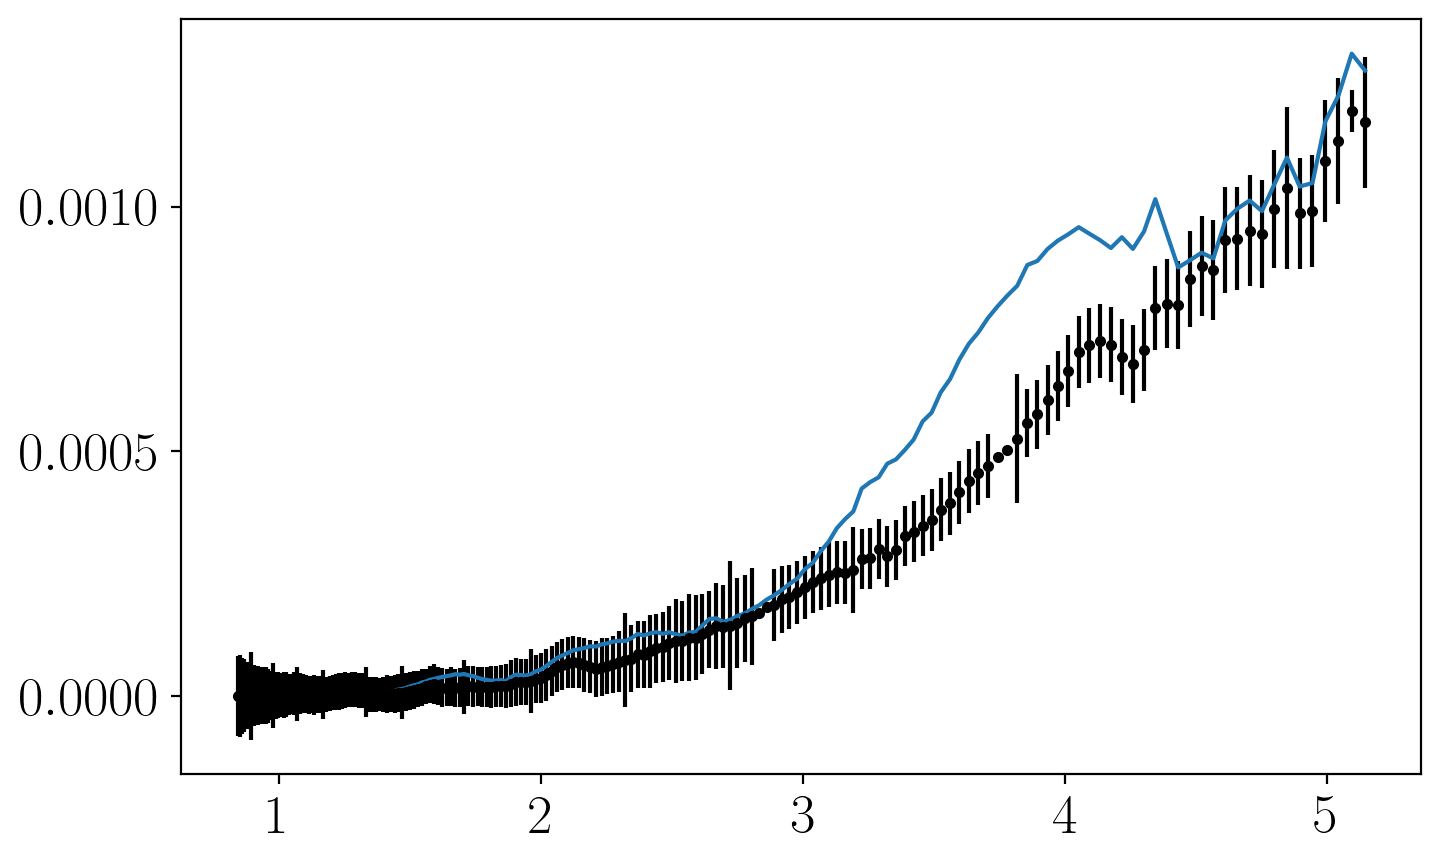

In [46]:
plt.plot(wl, Fplan_therm_earth/Fstar_earth)
plt.errorbar(wl, y_binned/Fstar_earth - 1, yerr = (y_err/Fstar_earth), fmt = ".k")